# Preliminaries

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
from matplotlib import pyplot as plt
from matplotlib import cm
import msgpack

from stellarpunk import econ_sim, serialization

In [2]:
%load_ext autoreload
%autoreload 1
%aimport stellarpunk.serialization
%aimport stellarpunk.econ_sim

# Data Loading

## Economic Model

In [3]:
#production_chain_df = pd.DataFrame(msgpack.unpackb(open("/tmp/production_chain.log", "rb").read(), object_hook=serialization.decode_matrix))
production_chain = serialization.load_production_chain(open("/tmp/production_chain.log", "rb").read())
production_chain_df = production_chain.adj_matrix

In [4]:
production_chain_df.shape

(26, 26)

In [5]:
agent_goods_df = pd.DataFrame(msgpack.unpackb(open("/tmp/agent_goods.log", "rb").read(), object_hook=serialization.decode_matrix))

In [6]:
agent_goods_df

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
production_goods = agent_goods_df @ production_chain_df.T

## Loading Other Data

In [8]:
buy_price_df = serialization.read_tick_log_to_df(open("/tmp/buy_prices.log", "rb"), index_name="agent").reset_index()
buy_budget_df = serialization.read_tick_log_to_df(open("/tmp/buy_budget.log", "rb"), index_name="agent").reset_index()
sell_price_df = serialization.read_tick_log_to_df(open("/tmp/sell_prices.log", "rb"), index_name="agent", fill_values=np.inf).reset_index()
max_buy_price_df = serialization.read_tick_log_to_df(open("/tmp/max_buy_prices.log", "rb"), index_name="agent").reset_index()
min_sell_price_df = serialization.read_tick_log_to_df(open("/tmp/min_sell_prices.log", "rb"), index_name="agent", fill_values=np.inf).reset_index()

In [9]:
columns = ["tick", "product", "buyer", "seller", "price", "amount"]
transaction_df = pd.read_csv("/tmp/transactions.log", sep="\t", header=None, names=columns)

In [10]:
transaction_df["value"] = transaction_df["amount"] * transaction_df["price"]

In [11]:
cannot_buy_df = serialization.read_tick_log_to_df(open("/tmp/cannot_buy.log", "rb"), index_name="agent", fill_values=0.).reset_index()
cannot_sell_df = serialization.read_tick_log_to_df(open("/tmp/cannot_sell.log", "rb"), index_name="agent", fill_values=0.).reset_index()

In [12]:
balance_df = serialization.read_tick_log_to_df(open("/tmp/balance.log", "rb"), index_name="agent", column_names=["balance"])
balance_df.reset_index(inplace=True)

In [13]:
#columns = list(map(lambda x: str(x), range(production_chain_df.shape[0])))
columns=None
inventory_df = serialization.read_tick_log_to_df(open("/tmp/inventory.log", "rb"), index_name="agent", column_names=columns)
inventory_df.reset_index(inplace=True)

In [14]:
production_efficiency_df = serialization.read_tick_log_to_df(open("/tmp/production_efficiency.log", "rb"), index_name="agent")

# Transactions

## Market Overview

In [15]:
transaction_df.groupby("product")[["amount", "value"]].sum()

,amount,value
product,,
0,19203.0,1.292588e+05
1,28145.0,2.471648e+05
2,16945.0,7.174439e+04
3,40494.0,1.411258e+05
4,39556.0,1.455421e+05
5,39653.0,2.453618e+05
6,19199.0,1.003175e+06
7,28128.0,2.699344e+05
8,16933.0,8.249099e+04


Text(0.5, 1.0, 'transaction count by tick')

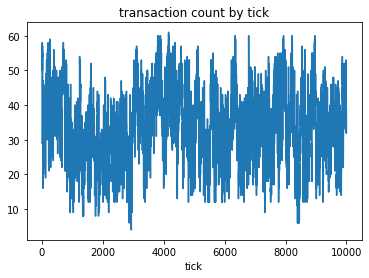

In [16]:
transaction_df.groupby("tick")["price"].count().plot()
plt.title("transaction count by tick")

Text(0.5, 1.0, 'product 0 transaction count per tick')

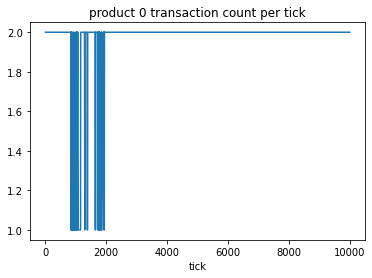

In [17]:
transaction_df[transaction_df["product"] == 0].groupby("tick")["price"].count().plot()
plt.title("product 0 transaction count per tick")

Text(0.5, 1.0, 'transaction unit quantity per tick')

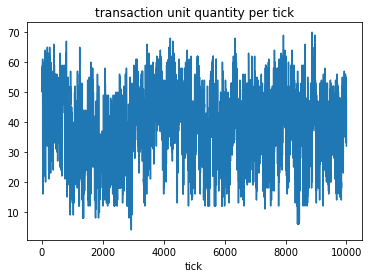

In [18]:
transaction_df.groupby("tick")["amount"].sum().plot()
plt.title("transaction unit quantity per tick")

Text(0.5, 1.0, 'transaction value per tick')

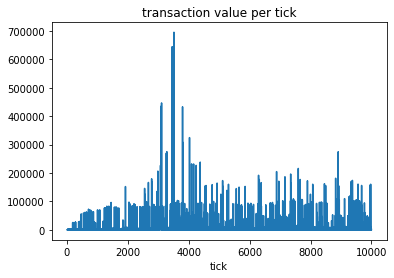

In [19]:
transaction_df.groupby("tick")["value"].sum().plot()
plt.title("transaction value per tick")

Text(0.5, 1.0, 'distinct products sold per tick')

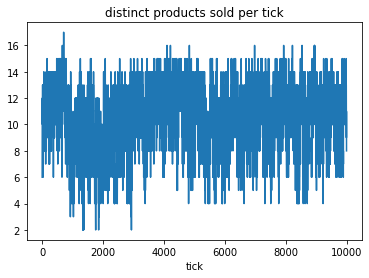

In [20]:
transaction_df.groupby("tick")["product"].nunique().plot()
plt.title("distinct products sold per tick") 

Text(0.5, 1.0, 'distinct sellers per tick')

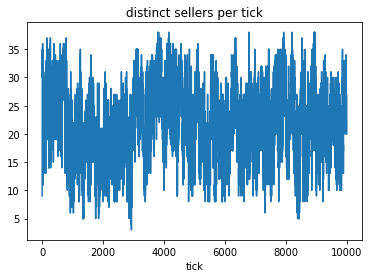

In [21]:
transaction_df.groupby("tick")["seller"].nunique().plot()
plt.title("distinct sellers per tick")

Text(0.5, 1.0, 'distinct buyers per tick')

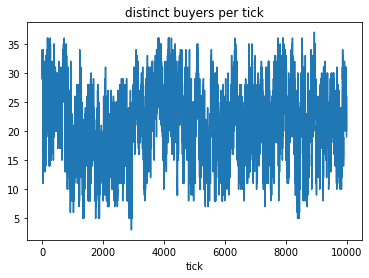

In [22]:
transaction_df.groupby("tick")["buyer"].nunique().plot()
plt.title("distinct buyers per tick")

In [23]:
transaction_df["seller"].nunique()

85

In [24]:
transaction_df["buyer"].nunique()

87

In [25]:
transaction_df["product"].nunique()

23

<AxesSubplot:>

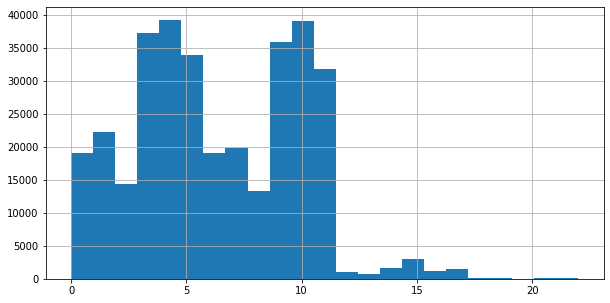

In [26]:
plt.figure(figsize=(10,5))
transaction_df["product"].hist(bins=transaction_df["product"].nunique())

Text(0.5, 1.0, 'max product id sold each tick')

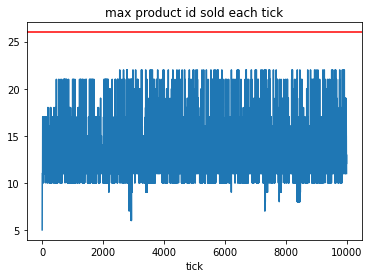

In [27]:
transaction_df.groupby("tick")["product"].max().plot()
plt.axhline(production_chain_df.shape[1], color="red")
plt.title("max product id sold each tick")

## Further Exploration

In [28]:
transaction_df[transaction_df["seller"] == 3]["price"].describe()

count    24474.000000
mean         3.468320
std          0.237519
min          3.374772
25%          3.376956
50%          3.393227
75%          3.414215
max          7.980000
Name: price, dtype: float64

Text(0.5, 1.0, 'price of product 0 over time')

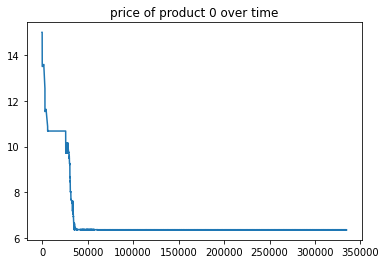

In [29]:
transaction_df[transaction_df["seller"] == 0]["price"].plot()
plt.title("price of product 0 over time")

Text(0.5, 1.0, 'price of product 2 over time')

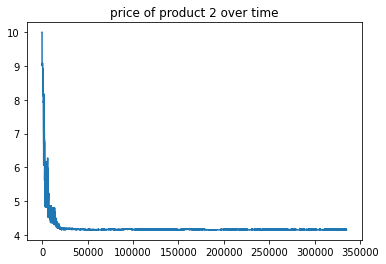

In [30]:
transaction_df[transaction_df["seller"] == 2]["price"].plot()
plt.title("price of product 2 over time")

Text(0.5, 1.0, 'price of product 6 over time')

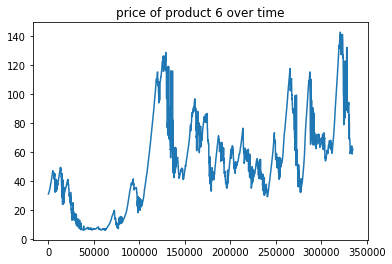

In [31]:
transaction_df[transaction_df["seller"] == 6]["price"].plot()
plt.title("price of product 6 over time")

<AxesSubplot:>

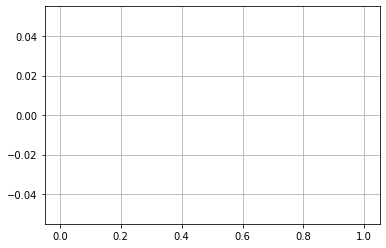

In [32]:
transaction_df[transaction_df["buyer"] == 3]["price"].hist()

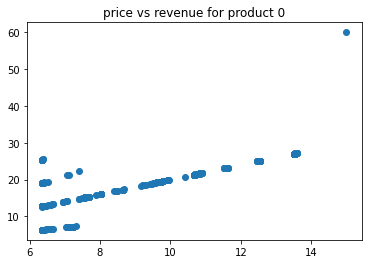

In [33]:
plt.scatter(transaction_df[transaction_df["product"] == 0].groupby("tick")["price"].mean(), transaction_df[transaction_df["product"] == 0].groupby("tick")["value"].sum())
plt.title("price vs revenue for product 0")
plt.show()

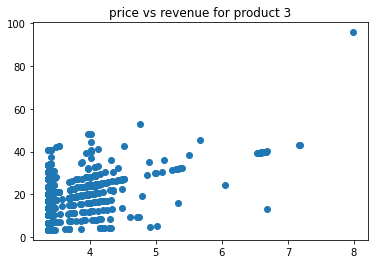

In [34]:
plt.scatter(transaction_df[transaction_df["product"] == 3].groupby("tick")["price"].mean(), transaction_df[transaction_df["product"] == 3].groupby("tick")["value"].sum())
plt.title("price vs revenue for product 3")
plt.show()

In [35]:
transaction_df[(transaction_df["price"] > 12) & (transaction_df["product"] == 0)]

,tick,product,buyer,seller,price,amount,value
6,2,0,6,0,15.000000,2.0,30.000000
7,2,0,40,0,15.000000,2.0,30.000000
35,3,0,6,0,13.509711,1.0,13.509711
36,3,0,40,0,13.509711,1.0,13.509711
93,4,0,6,0,13.499844,1.0,13.499844
...,...,...,...,...,...,...,...
2963,79,0,40,78,12.554142,1.0,12.554142
3005,80,0,6,78,12.556642,1.0,12.556642
3006,80,0,40,78,12.556642,1.0,12.556642
3045,81,0,6,0,12.537433,1.0,12.537433


## Transaction Graph

In [36]:
transaction_df.groupby(["buyer", "seller"])["amount"].sum().to_frame().reset_index()

,buyer,seller,amount
0,6,0,6381.0
1,6,78,3199.0
2,7,1,3061.0
3,7,44,1516.0
4,8,2,2903.0
...,...,...,...
910,99,34,2.0
911,99,62,1.0
912,99,74,2.0
913,99,85,3.0


In [37]:
G = nx.from_pandas_edgelist(
    transaction_df.groupby(["buyer", "seller"])["amount"].sum().to_frame().reset_index(),
    source="seller", target="buyer", edge_attr="amount", create_using=nx.DiGraph)

In [38]:
labels = pd.DataFrame(transaction_df.groupby("seller")["product"].first()).apply(lambda x: f'{x.name}:{x["product"]}', axis=1)

In [39]:
G = nx.relabel_nodes(G, labels)

In [40]:
nx.is_directed_acyclic_graph(G)

True

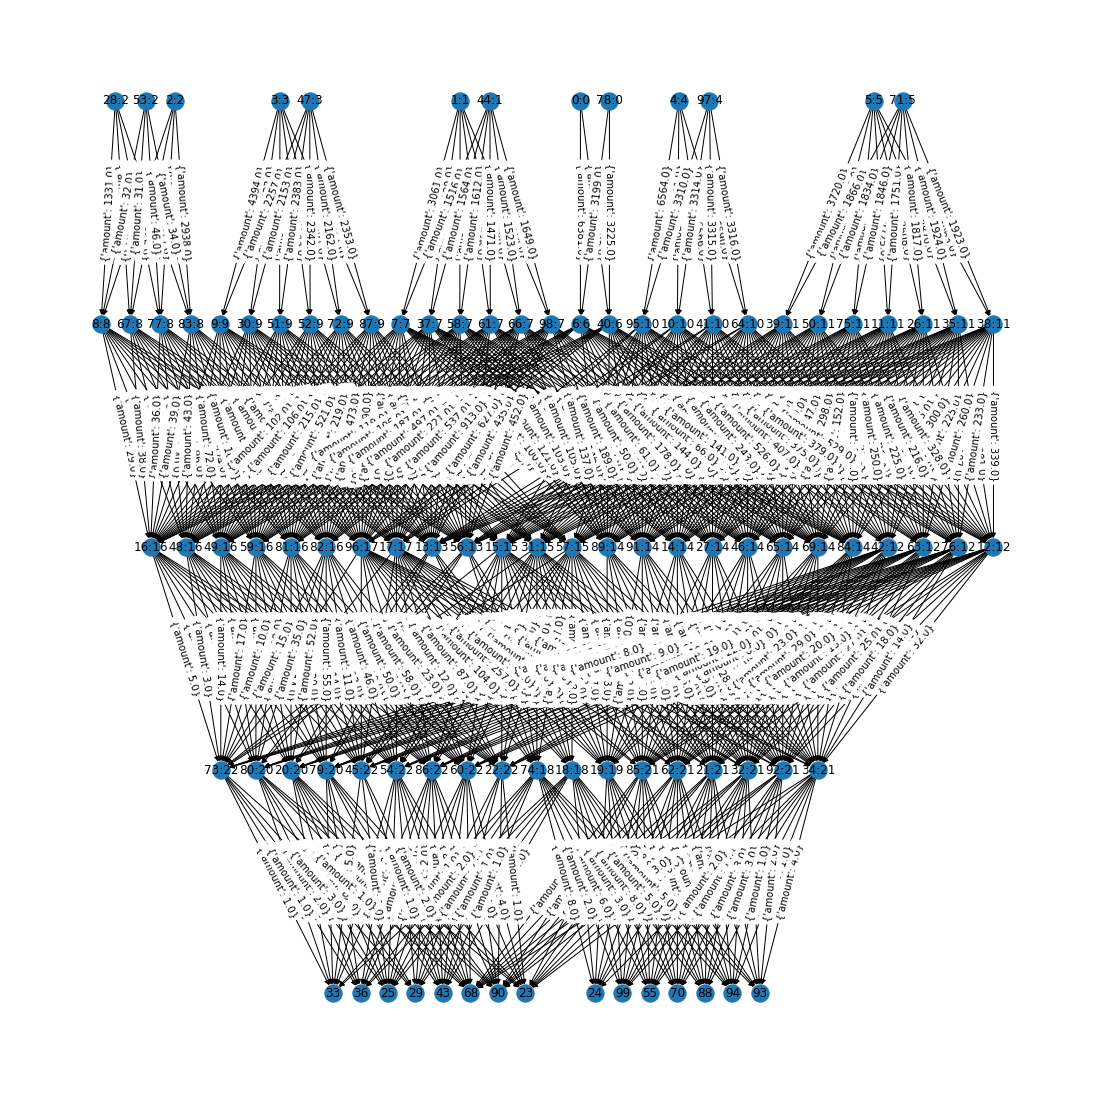

In [41]:
plt.figure(figsize=(15, 15))
#nx.draw_kamada_kawai(G, arrows=True)
pos = graphviz_layout(G, prog='dot')
nx.draw(G, pos, with_labels=True, arrows=True)
nx.draw_networkx_edge_labels(G, pos)
plt.show()

# Balance

In [42]:
balance_df[balance_df["tick"] == balance_df["tick"].min()].set_index("agent")

,tick,balance
agent,,
0,0,6.864870e+02
1,0,8.134284e+02
2,0,4.585230e+02
3,0,3.662527e+02
4,0,2.268773e+02
...,...,...
95,0,3.500000e+02
96,0,4.170000e+04
97,0,2.268773e+02


In [43]:
balance_df[balance_df["tick"] == balance_df["tick"].max()].set_index("agent")

,tick,balance
agent,,
0,10000,5.381446e+03
1,10000,2.406619e+03
2,10000,1.593261e+03
3,10000,2.800724e+03
4,10000,3.616437e+04
...,...,...
95,10000,8.602082e+05
96,10000,6.716226e+05
97,10000,1.837664e+04


In [44]:
#balance_df.groupby("tick")["balance"].sum().plot()

In [45]:
balance_df[balance_df["tick"] == balance_df["tick"].min()]["balance"].describe()

count    1.000000e+02
mean     1.886496e+08
std      6.669094e+08
min      2.268773e+02
25%      9.500000e+02
50%      2.250000e+04
75%      9.735500e+05
max      2.604338e+09
Name: balance, dtype: float64

In [46]:
balance_df[balance_df["tick"] == balance_df["tick"].max()]["balance"].describe()

count    1.000000e+02
mean     1.887533e+08
std      6.659737e+08
min      5.573994e+02
25%      5.192914e+03
50%      5.935174e+05
75%      1.443584e+06
max      2.601380e+09
Name: balance, dtype: float64

In [47]:
ltb_df = balance_df[balance_df["tick"] == balance_df["tick"].max()]

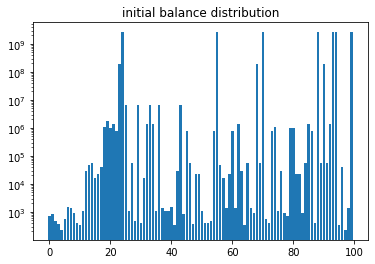

In [48]:
plt.bar(balance_df[balance_df["tick"] == balance_df["tick"].min()]["agent"], balance_df[balance_df["tick"] == balance_df["tick"].min()]["balance"])
plt.title("initial balance distribution")
plt.yscale("log")

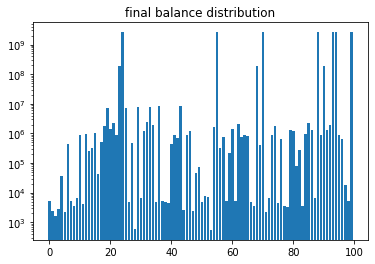

In [49]:
plt.bar(balance_df[balance_df["tick"] == balance_df["tick"].max()]["agent"], balance_df[balance_df["tick"] == balance_df["tick"].max()]["balance"])
plt.title("final balance distribution")
plt.yscale("log")

In [50]:
balance_df[balance_df["tick"] == balance_df["tick"].max()].set_index("agent")["balance"]-balance_df[balance_df["tick"] == balance_df["tick"].min()].set_index("agent")["balance"]

agent
0     4.694959e+03
1     1.593191e+03
2     1.134738e+03
3     2.434472e+03
4     3.593749e+04
          ...     
95    8.598582e+05
96    6.299226e+05
97    1.814976e+04
98    4.001099e+03
99   -3.476453e+06
Name: balance, Length: 100, dtype: float64

In [51]:
balance_df[balance_df["tick"] == balance_df["tick"].max()].set_index("agent")["balance"]

agent
0     5.381446e+03
1     2.406619e+03
2     1.593261e+03
3     2.800724e+03
4     3.616437e+04
          ...     
95    8.602082e+05
96    6.716226e+05
97    1.837664e+04
98    5.401099e+03
99    2.600862e+09
Name: balance, Length: 100, dtype: float64

In [52]:
balance_df[balance_df["tick"] == balance_df["tick"].max()].head(50)

,agent,tick,balance
1000000,0,10000,5.381446e+03
1000001,1,10000,2.406619e+03
1000002,2,10000,1.593261e+03
1000003,3,10000,2.800724e+03
1000004,4,10000,3.616437e+04
1000005,5,10000,2.247285e+03
1000006,6,10000,4.386531e+05
1000007,7,10000,5.193708e+03
1000008,8,10000,3.714259e+03
1000009,9,10000,6.647435e+03


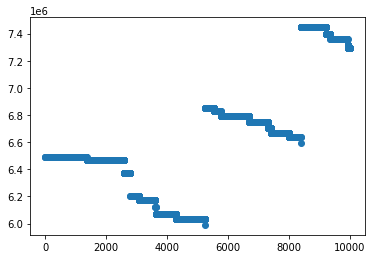

In [53]:
plt.scatter(balance_df[balance_df["agent"] == 23]["tick"],balance_df[balance_df["agent"] == 25]["balance"])

In [54]:
#for agent in balance_df["agent"].unique():
#    plt.scatter(balance_df[balance_df["agent"] == agent]["tick"], balance_df[balance_df["agent"] == agent]["balance"])


In [55]:
balance_df[balance_df["tick"] == balance_df["tick"].max()].drop("tick", axis=1).set_index("agent") / balance_df[balance_df["tick"] == balance_df["tick"].min()].drop("tick", axis=1).set_index("agent")

,balance
agent,
0,7.839108
1,2.958612
2,3.474768
3,7.646972
4,159.400551
...,...
95,2457.737582
96,16.106058
97,80.998119


# Inventory

## Last Tick Inventory

In [56]:
inventory_df[inventory_df["tick"] == inventory_df["tick"].max()]

,agent,tick,0,1,2,3,4,5,6,7,...,16,17,18,19,20,21,22,23,24,25
1000000,0,10000,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000001,1,10000,0.0,19.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000002,2,10000,0.0,0.0,19.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000003,3,10000,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000004,4,10000,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000095,95,10000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000096,96,10000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000097,97,10000,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000098,98,10000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Produced Goods Inventory

In [57]:
agent_goods_df * inventory_df[inventory_df["tick"] == inventory_df["tick"].max()].set_index("agent")

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,tick
0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,0.0,19.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2,0.0,0.0,19.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
4,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
97,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
98,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


### Input Resources Inventory

In [58]:
inventory_df[inventory_df["tick"] == inventory_df["tick"].max()].set_index("agent") - agent_goods_df * inventory_df[inventory_df["tick"] == inventory_df["tick"].max()].set_index("agent")

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,tick
agent,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,8.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
97,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


In [59]:
(inventory_df[inventory_df["tick"] == inventory_df["tick"].max()].set_index("agent") - agent_goods_df * inventory_df[inventory_df["tick"] == inventory_df["tick"].max()].set_index("agent")) - (agent_goods_df @ production_chain_df.T)

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,tick
agent,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,-7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
97,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


## Production Surplus/Deficit

In [60]:
agent_id = 16
inv_s = inventory_df[inventory_df["tick"] == inventory_df["tick"].max()].set_index("agent").loc[agent_id].drop("tick")
need_s = (agent_goods_df.loc[agent_id] @ production_chain_df.T)
batch_s = (agent_goods_df * production_chain.batch_sizes[np.newaxis,:]).loc[agent_id] @ production_chain_df.T
deficit_df = pd.DataFrame({"inventory":inv_s, "unit_need":need_s, "batch_need": batch_s, "surplus":inv_s - batch_s, "batches":inv_s/batch_s})
deficit_df

,inventory,unit_need,batch_need,surplus,batches
0,0.0,0.0,0.0,0.0,NaN
1,0.0,0.0,0.0,0.0,NaN
2,0.0,0.0,0.0,0.0,NaN
3,0.0,0.0,0.0,0.0,NaN
4,0.0,0.0,0.0,0.0,NaN
5,0.0,0.0,0.0,0.0,NaN
6,3.0,3.0,3.0,0.0,1.000
7,16.0,8.0,8.0,8.0,2.000
8,2.0,2.0,2.0,0.0,1.000
9,1.0,8.0,8.0,-7.0,0.125


In [61]:
balance_df[(balance_df["agent"] == agent_id) & (balance_df["tick"] == balance_df["tick"].max())]

,agent,tick,balance
1000016,16,10000,43814.176306


In [62]:
buy_budget_df[(buy_budget_df["tick"] == buy_budget_df["tick"].max()) & (buy_budget_df["agent"] == agent_id)].T

,1000016
agent,16.000000
tick,10000.000000
0,0.000000
1,0.000000
2,0.000000
3,0.000000
4,0.000000
5,0.000000
6,151.420528
7,0.000000


In [63]:
inventory_df[inventory_df["agent"] == agent_id].drop("agent", axis=1).set_index("tick")[agent_id].describe()

count    10001.000000
mean         0.273873
std          0.695907
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          3.000000
Name: 16, dtype: float64

# Buy and Sell Prices

In [64]:
max_last_buy_price = buy_price_df[buy_price_df["tick"] == buy_price_df["tick"].max()].drop(["agent", "tick"], axis=1).max(axis=0)
min_last_sell_price = sell_price_df[sell_price_df["tick"] == sell_price_df["tick"].max()].drop(["agent", "tick"], axis=1).min(axis=0)
#max_last_buy_price - min_last_sell_price
min_last_sell_price

0     6.351296e+00
1     8.657160e+00
2     4.147701e+00
3     3.374727e+00
4     2.312269e+00
5     6.101928e+00
6     1.031075e+01
7     8.657598e+00
8     4.148938e+00
9     3.491180e+00
10    5.375894e+00
11    6.119632e+00
12    2.215620e+03
13    2.887169e+02
14    2.017642e+03
15    8.304661e+02
16    3.914103e+02
17    7.340179e+02
18    2.307585e+04
19    1.497361e+05
20    2.587668e+04
21    7.676345e+04
22    3.862338e+04
23    9.016816e+06
24    1.388674e+08
25    8.509135e+05
dtype: float64

## Market Analysis for one Good

In [65]:
product_id = 18
min_ticks = 0
max_ticks = np.inf

df1 = sell_price_df[(sell_price_df[product_id] < np.inf) & (sell_price_df["tick"].between(min_ticks,max_ticks))].groupby("tick")[product_id].min().to_frame().reset_index()
dfms = min_sell_price_df[(min_sell_price_df[product_id] < np.inf) & (min_sell_price_df["tick"].between(min_ticks, max_ticks))].groupby("tick")[product_id].min().to_frame().reset_index()
df2 = buy_price_df[(buy_price_df["tick"].between(min_ticks, max_ticks)) & (buy_price_df[product_id] > 0)][["tick", "agent", product_id]]
df2[product_id] = df2[product_id]
dfmb = max_buy_price_df[(max_buy_price_df["tick"].between(min_ticks, max_ticks)) & (max_buy_price_df[product_id] > 0)][["tick", "agent", product_id]]
dfmb[product_id] = dfmb[product_id]

buyer_df = buy_budget_df[buy_budget_df[product_id] > 0][["tick", "agent", product_id]].merge(df2, on=["tick", "agent"], suffixes=["_budget", "_price"])
buyer_df["units"] = buyer_df[f'{product_id}_budget'] / buyer_df[f'{product_id}_price']
seller_df = inventory_df[inventory_df["agent"].isin(np.where(agent_goods_df[product_id])[0])].groupby("tick")[product_id].sum()
seller_df = seller_df.loc[min_ticks:max_ticks]


3.0


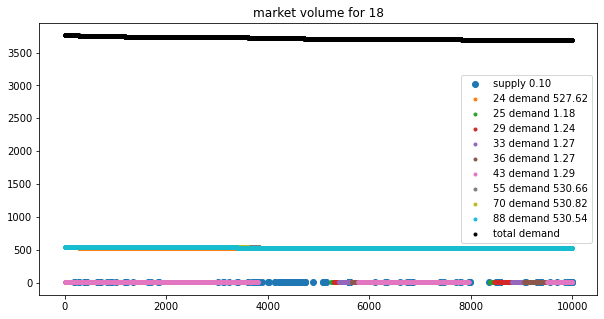

In [66]:
colors = plt.rcParams['axes.prop_cycle'].by_key()["color"]
plt.figure(figsize=(10,5))
plt.scatter(seller_df[seller_df>0].index, seller_df[seller_df>0], label=f'supply {seller_df.mean():.2f}')
for agent_id, color in zip(buyer_df["agent"].unique(), colors[1:]):
    plt.scatter(buyer_df[buyer_df["agent"] == agent_id]["tick"], buyer_df[buyer_df["agent"] == agent_id]["units"], label=f'{agent_id} demand {buyer_df[buyer_df["agent"] == agent_id]["units"].mean():.2f}', marker=".")
total_demand = buyer_df.groupby("tick")["units"].sum()
plt.scatter(total_demand.index, total_demand, label="total demand", marker=".", color="black")
plt.legend(loc="right")
plt.title(f'market volume for {product_id}')
print(seller_df.max())

Text(0.5, 1.0, 'price chart for 18')

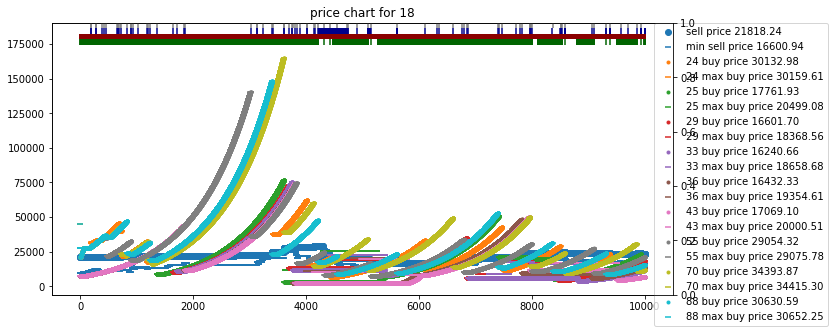

In [67]:
colors = plt.rcParams['axes.prop_cycle'].by_key()["color"]
plt.figure(figsize=(15,5))
plt.scatter(df1["tick"], df1[product_id], label=f'sell price {df1[product_id].mean():.2f}', color=colors[0])
plt.scatter(dfms["tick"], dfms[product_id], label=f'min sell price {dfms[product_id].mean():.2f}', marker="_", color=colors[0])
for agent, color in zip(df2["agent"].unique(), colors[1:]):
    plt.scatter(df2[df2["agent"] == agent]["tick"], df2[df2["agent"] == agent][product_id], label=f'{agent} buy price {df2[df2["agent"] == agent][product_id].mean():.2f}', marker=".", color=color)
    plt.scatter(dfmb[dfmb["agent"] == agent]["tick"], dfmb[dfmb["agent"] == agent][product_id], label=f'{agent} max buy price {dfmb[dfmb["agent"] == agent][product_id].mean():.2f}', marker="_", color=color)
plt.ylim(plt.ylim()[0], plt.ylim()[1]*1.1)

#plt.legend(loc="right")
plt.legend(bbox_to_anchor=(1.25, 1), borderaxespad=0)

# some status indicators
ax2 = plt.twinx()
ax2.vlines(transaction_df[(transaction_df["product"] == product_id) & transaction_df["tick"].between(min_ticks, max_ticks)]["tick"], ymin=0.98, ymax=1, color="gray")
ax2.vlines(seller_df[seller_df>0].index, ymin=0.96, ymax=0.98, color="darkblue")
ax2.vlines((buyer_df.groupby("tick")["units"].sum() > 0).index, ymin=0.94, ymax=0.96, color="darkred")
ax2.vlines(df1[(df2.groupby("tick")[product_id].max() - df1[product_id])>0].index, ymin=0.92, ymax=0.94, color="darkgreen")
ax2.set_ylim(0,1)
plt.subplots_adjust(right=0.7)

plt.title(f'price chart for {product_id}')

#plt.tight_layout(rect=[0, 0, 0.75, 1])



(0.0, 2734265275.840841)

<Figure size 432x288 with 0 Axes>

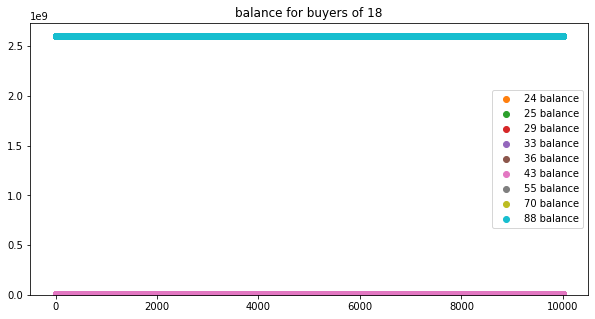

In [68]:
plt.subplots_adjust(right=0.7)
colors = plt.rcParams['axes.prop_cycle'].by_key()["color"]
plt.figure(figsize=(10,5))
for agent, color in zip(df2["agent"].unique(), colors[1:]):
    plt.scatter(balance_df[balance_df["agent"] == agent]["tick"], balance_df[balance_df["agent"] == agent]["balance"], color=color, label=f'{agent} balance')
plt.title(f'balance for buyers of {product_id}')
plt.legend(loc="right")
plt.ylim(0)

In [69]:
transaction_df[transaction_df["product"] == product_id].groupby("buyer")["amount"].sum()

buyer
24    13.0
25     4.0
29     3.0
33     3.0
36     3.0
43     3.0
55    10.0
70    10.0
88    10.0
93     8.0
94     9.0
99    10.0
Name: amount, dtype: float64

In [70]:
transaction_df[transaction_df["product"] == product_id].groupby("buyer")["tick"].describe()

,count,mean,std,min,25%,50%,75%,max
buyer,,,,,,,,
24,13.0,3550.307692,3407.601732,186.0,283.00,3409.0,6108.00,9390.0
25,4.0,5579.500000,3834.118108,1351.0,3049.00,5514.5,8045.00,9938.0
29,3.0,4059.000000,2626.198012,1635.0,2664.00,3693.0,5271.00,6849.0
33,3.0,4112.666667,2602.190872,1706.0,2732.00,3758.0,5316.00,6874.0
36,3.0,4470.333333,3055.739736,1833.0,2796.00,3759.0,5789.00,7819.0
43,3.0,4540.333333,3119.648110,1852.0,2830.00,3808.0,5884.50,7961.0
55,9.0,4609.000000,2988.842460,383.0,3017.00,4324.0,6789.00,9095.0
70,10.0,4819.600000,3399.097207,427.0,1796.75,4615.5,7632.00,9855.0
88,10.0,4537.900000,3155.451595,449.0,1776.75,4383.5,6955.25,9316.0


In [71]:
transaction_df[transaction_df["product"] == product_id].groupby("buyer")["price"].describe()

,count,mean,std,min,25%,50%,75%,max
buyer,,,,,,,,
24,13.0,33292.120999,17555.634049,20482.463034,25409.404080,27135.041174,31895.507896,86431.053696
25,4.0,34399.595831,13654.524077,23143.130212,24179.481894,31005.748630,41225.862567,52443.755851
29,3.0,36348.417608,12199.927166,28991.846820,29307.138991,29622.431162,40026.703003,50430.974844
33,3.0,36901.094183,13092.859934,28367.331465,29363.855033,30360.378601,41167.975543,51975.572484
36,3.0,40750.297421,11937.187478,32732.966990,33890.857852,35048.748713,44758.962637,54469.176561
43,3.0,42255.552585,12118.210332,33204.981421,35371.860323,37538.739225,46780.838167,56022.937109
55,9.0,34340.214981,20087.730868,16875.822446,25483.235858,27199.524017,27877.045773,81695.039850
70,10.0,38319.780023,21138.503771,24077.801856,27645.771417,30732.492410,37223.622907,95930.338659
88,10.0,35670.595918,19568.678442,21282.105806,24673.392318,28498.966629,37674.476094,87705.563914


### Buy/Sell Price Investigation

In [72]:
df1[product_id].describe()

count    10001.000000
mean     21818.244840
std       3056.118076
min      16833.657658
25%      20676.814904
50%      21950.525325
75%      23781.428779
max      29009.002103
Name: 18, dtype: float64

In [73]:
df2.groupby("agent")[product_id].describe()

,count,mean,std,min,25%,50%,75%,max
agent,,,,,,,,
24,10001.0,30132.975394,24982.133121,6849.912396,14612.204669,22188.683262,35603.592985,145845.522994
25,10001.0,17761.926165,14395.571967,3226.191609,7705.855701,14432.606608,21149.251497,77064.760338
29,10001.0,16601.702649,12549.909242,4413.253824,8198.486312,13144.978329,19619.291294,72900.084567
33,10001.0,16240.663033,13264.850517,3949.324104,6294.265707,11900.326319,19806.343273,75515.142549
36,10001.0,16432.330330,14368.779114,2148.214604,7523.934407,10967.110278,23101.922498,71196.892400
43,10001.0,17069.104650,14979.670921,2159.683518,5855.863573,11739.438374,23896.351351,74303.544972
55,10001.0,29054.321264,24757.010576,7217.536786,13388.235820,20707.599196,32290.230674,140525.825951
70,10001.0,34393.869331,27442.089251,9621.693732,18093.933541,26088.896756,39199.192625,164921.887891
88,10001.0,30630.585541,25018.510926,8685.961707,15069.942965,23338.290639,35742.201107,148473.359852


In [74]:
df2[df2["tick"] == df2["tick"].max()][product_id].max() - df1[product_id].iloc[-1]

186.80129716176816

In [75]:
(df2.groupby("tick")[product_id].max() - df1.set_index("tick")[product_id]).describe()

count     10001.000000
mean      23776.374115
std       31549.484934
min       -6981.783063
25%        3591.337070
50%       13538.270262
75%       27326.464071
max      139256.988925
Name: 18, dtype: float64

In [76]:
dfmb[dfmb["tick"] == dfmb["tick"].max()][product_id].max() - dfms[product_id].iloc[-1]

7057.3976657743915

In [77]:
(dfmb.groupby("tick")[product_id].max() - dfms.set_index("tick")[product_id]).describe()

count     10001.000000
mean      29406.714470
std       31368.058404
min       -1296.542417
25%        9316.871041
50%       18894.112980
75%       32661.161457
max      143818.744123
Name: 18, dtype: float64

In [78]:
bp_s = (production_goods.loc[product_id] * buy_price_df[buy_price_df["agent"] == product_id].drop(["agent", "tick"], axis=1)).sum(axis=1)
mbp_s = (production_goods.loc[product_id] * max_buy_price_df[max_buy_price_df["agent"] == product_id].drop(["agent", "tick"], axis=1)).sum(axis=1)
sp_s = sell_price_df[sell_price_df["agent"] == product_id].drop(["agent", "tick"], axis=1).min(axis=1)
msp_s = min_sell_price_df[min_sell_price_df["agent"] == product_id].drop(["agent", "tick"], axis=1).min(axis=1)
price_df = pd.DataFrame({"cost":bp_s, "max_cost":mbp_s, "price":sp_s, "min_price":msp_s, "unit_profit":sp_s-bp_s})
price_df

,cost,max_cost,price,min_price,unit_profit
18,9716.000000,18817.171083,20987.000000,9716.693320,11271.000000
118,9716.000000,20987.000000,20987.000000,9716.000000,11271.000000
218,9764.580000,20987.000000,20987.000000,9716.000000,11222.420000
318,9813.402900,20987.000000,20987.000000,9716.000000,11173.597100
418,9862.469914,20987.000000,20987.000000,9716.000000,11124.530086
...,...,...,...,...,...
999618,24857.822511,25315.501851,25241.457824,17936.731547,383.635313
999718,24857.822511,25315.501851,25241.457824,17936.731547,383.635313
999818,24857.822511,25315.501851,25241.457824,17936.731547,383.635313
999918,20672.188309,25315.501851,25241.457824,18165.868497,4569.269515


## Larger Scale Market Analysis

In [79]:
demand_units_df = (buy_budget_df.set_index(["agent", "tick"]) / buy_price_df.set_index(["agent", "tick"])).fillna(0.)
supply_units_df = (inventory_df.drop("tick", axis=1).set_index("agent") * agent_goods_df).rename_axis('agent').reset_index(level=0)
supply_units_df["tick"] = inventory_df["tick"]

In [80]:
demand_units_df.shape

(1000100, 26)

### Supply Deficit

For each product, on average how many units of supply above demand are on the market

In [81]:
transaction_df.groupby("product")["amount"].sum() / transaction_df["tick"].max()

product
0     1.9203
1     2.8145
2     1.6945
3     4.0494
4     3.9556
5     3.9653
6     1.9199
7     2.8128
8     1.6933
9     4.0482
10    3.9548
11    3.9636
12    0.0964
13    0.0731
14    0.1645
15    0.3035
16    0.1150
17    0.1455
18    0.0086
19    0.0048
20    0.0042
21    0.0163
22    0.0078
Name: amount, dtype: float64

In [82]:
demand_units_mean = demand_units_df.groupby("tick").sum().mean()
supply_units_mean = supply_units_df.groupby("tick").sum().mean().drop("agent")
surplus_df = pd.DataFrame({
    "supply": supply_units_mean,
    "supply_cv": ((supply_units_df.groupby("tick").sum()).std()/(supply_units_df.groupby("tick").sum()).mean()).drop("agent"),
    "demand": demand_units_mean,
    "demand_cv": (demand_units_df.groupby("tick").sum()).std()/(demand_units_df.groupby("tick").sum()).mean(),
    "surplus": supply_units_mean - demand_units_mean
})
surplus_df["min_input_surplus"] = 1./(pd.DataFrame(production_chain.adj_matrix).replace(0, np.nan).multiply(1./surplus_df["surplus"], axis=0).max(axis=0).fillna(np.inf))
surplus_df

,supply,supply_cv,demand,demand_cv,surplus,min_input_surplus
0,18.476252,7.042327,1.948405,0.199661,16.527847,0.000000
1,24.451255,7.132596,3.458154,0.852545,20.993101,0.000000
2,43.472153,5.827586,2.661934,0.825476,40.810219,0.000000
3,19.362964,7.128573,4.762624,0.517488,14.600340,0.000000
4,16.296070,7.038422,3.956004,0.138883,12.340066,0.000000
5,21.105289,7.105507,5.038396,0.603880,16.066893,0.000000
6,2.115088,7.172983,107.530947,0.280477,-105.415858,16.527847
7,11.227877,4.074785,47.991501,0.482668,-36.763624,20.993101
8,7.016698,5.176383,27.409959,0.466367,-20.393261,40.810219
9,8.860014,4.140752,62.014899,0.391658,-53.154885,14.600340


In [83]:
surplus_df["surplus"] + surplus_df["min_input_surplus"]

0       16.527847
1       20.993101
2       40.810219
3       14.600340
4       12.340066
5       16.066893
6      -88.888011
7      -15.770523
8       20.416958
9      -38.554545
10     -69.700130
11     -57.645535
12     -88.089058
13     -34.368396
14     -64.195747
15    -108.846195
16     -97.742759
17     -72.861581
18   -3729.324793
19   -3378.103740
20    -138.275506
21   -7265.856948
22    -224.189681
23    -168.426753
24     -14.341288
25   -3717.769023
dtype: float64

In [84]:
pd.DataFrame(production_chain.adj_matrix)[11]

0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
5     1.0
6     0.0
7     0.0
8     0.0
9     0.0
10    0.0
11    0.0
12    0.0
13    0.0
14    0.0
15    0.0
16    0.0
17    0.0
18    0.0
19    0.0
20    0.0
21    0.0
22    0.0
23    0.0
24    0.0
25    0.0
Name: 11, dtype: float64

## Cannot Buy or Sell

In [122]:
cannot_buy_df.set_index(["tick", "agent"]).max(axis=1).describe()

count    1.000100e+06
mean     2.588607e+02
std      5.382147e+02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      2.330000e+02
max      4.161000e+03
dtype: float64

In [123]:
cannot_sell_df.set_index(["tick", "agent"]).max(axis=1).describe()

count    1.000100e+06
mean     5.000433e+01
std      5.553579e+02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      9.760000e+03
dtype: float64

What product was being sold by the agent with the largest cannot sell ticks?

In [134]:
agent_goods_df.loc[cannot_sell_df.set_index(["tick", "agent"]).max(axis=1).index[cannot_sell_df.set_index(["tick", "agent"]).max(axis=1).argmax()][1]]

0     0.0
1     0.0
2     1.0
3     0.0
4     0.0
5     0.0
6     0.0
7     0.0
8     0.0
9     0.0
10    0.0
11    0.0
12    0.0
13    0.0
14    0.0
15    0.0
16    0.0
17    0.0
18    0.0
19    0.0
20    0.0
21    0.0
22    0.0
23    0.0
24    0.0
25    0.0
Name: 53, dtype: float64

# Profit Analysis

## Basic Profit = Revenue - Cost

Sum up all revenue (from transactions, final goods are sunk elsewhere)
Sum up all costs (from transactions, basic resources are sourced elsewhere)
Account for inventory (using latest market prices)

profit = costs - revenue + value_of_goods_on_hand

In [98]:
revenue = transaction_df.groupby("seller")["value"].sum().reindex(list(range(agent_goods_df.shape[0])), fill_value=0)
costs = transaction_df.groupby("buyer")["value"].sum().reindex(list(range(agent_goods_df.shape[0])), fill_value=0)

In [104]:
costs.describe()

count    1.000000e+02
mean     5.984756e+05
std      9.989547e+05
min      0.000000e+00
25%      3.138988e+04
50%      1.035964e+05
75%      7.441389e+05
max      4.749698e+06
Name: value, dtype: float64

In [105]:
revenue.describe()

count    1.000000e+02
mean     5.984756e+05
std      1.171056e+06
min      0.000000e+00
25%      3.082085e+04
50%      8.943556e+04
75%      8.998197e+05
max      1.000751e+07
Name: value, dtype: float64

Profit (without accounting for inventory value):

In [114]:
(revenue-costs).describe()

count    1.000000e+02
mean     9.313226e-12
std      1.195543e+06
min     -3.476453e+06
25%      3.697723e+03
50%      7.597311e+04
75%      6.135307e+05
max      5.257814e+06
Name: value, dtype: float64

How much value is sitting in inventory?

In [106]:
# estimate based on last price in the market
value_of_goods_on_hand = (inventory_df[inventory_df["tick"] == inventory_df["tick"].max()].drop("tick", axis=1).set_index("agent") * transaction_df.groupby("product")["price"].nth(-1)).fillna(0).sum(axis=1)
value_of_goods_on_hand.describe()

count    1.000000e+02
mean     2.766967e+05
std      7.971096e+05
min      7.190761e+00
25%      3.226534e+01
50%      5.014744e+02
75%      2.912159e+04
max      2.909354e+06
dtype: float64

In [109]:
revenue.mean() - costs.mean()

1.1641532182693481e-10

In [112]:
value_of_goods_on_hand.mean()/revenue.mean()

0.4623357081999667

Profit (accounting for value of goods on hand):

In [90]:
((revenue - costs) + value_of_goods_on_hand)

seller
0      85896.299023
1     164676.770589
2      49438.882209
3      93059.513726
4      96789.075524
          ...      
95    859987.773257
96    630518.033280
97     48811.593379
98      4028.585452
99   -661506.160889
Length: 100, dtype: float64

<AxesSubplot:>

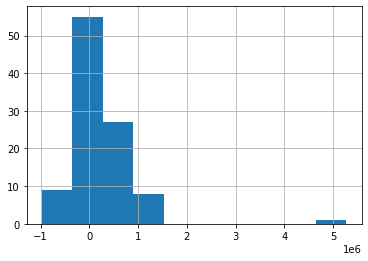

In [91]:
((revenue - costs) + value_of_goods_on_hand).hist()

## Further Investigation

### Who made Profit/Loss?

In [92]:
np.where(((revenue - costs) + value_of_goods_on_hand) < 0)

(array([23, 24, 25, 29, 33, 36, 43, 55, 68, 70, 88, 90, 93, 94, 99]),)

In [93]:
agent_goods_df[((revenue - costs) + value_of_goods_on_hand) < 0].idxmax(axis=1)

23    23
24    24
25    25
29    25
33    25
36    25
43    25
55    24
68    23
70    24
88    24
90    23
93    24
94    24
99    24
dtype: int64

### Recompute Profit from ending vs starting balance

And also account for value of goods on hand.

In [94]:
(balance_df[balance_df["tick"] == balance_df["tick"].max()].set_index("agent") - balance_df[balance_df["tick"] == balance_df["tick"].min()].set_index("agent"))["balance"]

agent
0     4.694959e+03
1     1.593191e+03
2     1.134738e+03
3     2.434472e+03
4     3.593749e+04
          ...     
95    8.598582e+05
96    6.299226e+05
97    1.814976e+04
98    4.001099e+03
99   -3.476453e+06
Name: balance, Length: 100, dtype: float64

<AxesSubplot:>

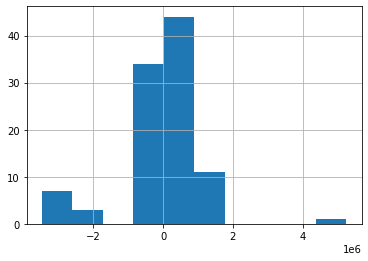

In [95]:
((balance_df[balance_df["tick"] == balance_df["tick"].max()].set_index("agent") - balance_df[balance_df["tick"] == balance_df["tick"].min()].set_index("agent"))["balance"]).hist()

<AxesSubplot:>

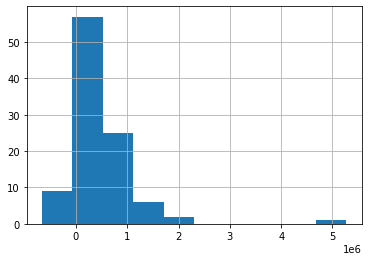

In [103]:
((balance_df[balance_df["tick"] == balance_df["tick"].max()].set_index("agent") - balance_df[balance_df["tick"] == balance_df["tick"].min()].set_index("agent"))["balance"] + value_of_goods_on_hand).hist()

# Production Efficiency